In [3]:
%pip install numpy pandas matplotlib seaborn scikit-learn

  Obtaining dependency information for numpy from https://files.pythonhosted.org/packages/18/90/a014805d627aa5750f6f0e878172afb6454552da929144b3c07fcae1bb13/numpy-2.3.4-cp312-cp312-macosx_11_0_arm64.whl.metadata
  Using cached numpy-2.3.4-cp312-cp312-macosx_11_0_arm64.whl.metadata (62 kB)
  Obtaining dependency information for pandas from https://files.pythonhosted.org/packages/5c/bd/bf8064d9cfa214294356c2d6702b716d3cf3bb24be59287a6a21e24cae6b/pandas-2.3.3-cp312-cp312-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for pandas from https://files.pythonhosted.org/packages/5c/bd/bf8064d9cfa214294356c2d6702b716d3cf3bb24be59287a6a21e24cae6b/pandas-2.3.3-cp312-cp312-macosx_11_0_arm64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/91.2 kB ? eta -:--:--  Downloading pandas-2.3.3-cp312-cp312-macosx_11_0_arm64.whl.metadata (91 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 1.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
# Import Required Libraries
import json
import os
from pathlib import Path
from collections import defaultdict, Counter
import numpy as np
import pandas as pd
from typing import Dict, List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from itertools import combinations

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Load Label Studio JSONs

In [ ]:
class LabelStudioAnalyzer:
    def __init__(self, json_dir: str):
        self.json_dir = json_dir
        self.annotations = []
        self.tasks = defaultdict(list)
        
    def load_jsons(self):
        """Load all JSON files from directory"""
        json_files = list(Path(self.json_dir).glob("*.json"))
        print(f"Found {len(json_files)} JSON files")
        
        loaded_count = 0
        failed_files = []
        
        for json_file in json_files:
            # Skip notebook files
            if json_file.suffix == '.ipynb':
                continue
                
            try:
                with open(json_file, 'r', encoding='utf-8') as f:
                    data = json.load(f)
                    if isinstance(data, list):
                        self.annotations.extend(data)
                    else:
                        self.annotations.append(data)
                    loaded_count += 1
                    print(f"✓ Loaded: {json_file.name}")
            except json.JSONDecodeError as e:
                failed_files.append((json_file.name, str(e)))
                print(f"✗ Failed to parse: {json_file.name}")
            except Exception as e:
                failed_files.append((json_file.name, str(e)))
                print(f"✗ Error loading: {json_file.name}")
        
        print(f"\nSuccessfully loaded {loaded_count} files")
        print(f"Total annotations: {len(self.annotations)}")
        
        if failed_files:
            print(f"\nFailed files ({len(failed_files)}):")
            for fname, error in failed_files:
                print(f"  - {fname}: {error[:50]}")
        
        self._organize_by_task()
    
    def _organize_by_task(self):
        """Organize annotations by task ID"""
        for annotation in self.annotations:
            task_id = annotation.get('id', annotation.get('task_id', annotation.get('task', 'unknown')))
            self.tasks[task_id].append(annotation)
        
        print(f"Organized into {len(self.tasks)} unique tasks")
    
    def extract_labels(self, annotation: Dict) -> List[str]:
        """Extract labels from a single annotation"""
        labels = []
        
        # Handle different Label Studio export formats
        if 'annotations' in annotation:
            for ann in annotation['annotations']:
                if 'result' in ann:
                    for result in ann['result']:
                        if 'value' in result and 'choices' in result['value']:
                            labels.extend(result['value']['choices'])
                        elif 'value' in result and 'text' in result['value']:
                            labels.append(result['value']['text'])
        
        elif 'result' in annotation:
            for result in annotation['result']:
                if 'value' in result and 'choices' in result['value']:
                    labels.extend(result['value']['choices'])
                elif 'value' in result and 'text' in result['value']:
                    labels.append(result['value']['text'])
        
        return labels

# Initialize analyzer - UPDATE THIS PATH to your Label Studio exports folder
json_directory = "/Users/agotabenjoe/Egyetem/Msc/2 felev/melytanulas/vitmma19_wfxbhi_legaltext/notebook"
analyzer = LabelStudioAnalyzer(json_directory)
analyzer.load_jsons()

# Print sample of first annotation to understand structure
if analyzer.annotations:
    print("\n" + "="*60)
    print("SAMPLE ANNOTATION STRUCTURE:")
    print("="*60)
    print(json.dumps(analyzer.annotations[0], indent=2)[:500] + "...")

Found 5 JSON files
✓ Loaded: R1Q6I8.json
✓ Loaded: WFXBHI.json
✓ Loaded: SS0N7G.json
✗ Failed to parse: BP17IB.json
✓ Loaded: HW921K.json

Successfully loaded 4 files
Total annotations: 348

Failed files (1):
  - BP17IB.json: Expecting value: line 1 column 1 (char 0)
Organized into 318 unique tasks


## 2. Advanced Consensus Metrics

Calculate multiple inter-annotator agreement metrics:
- **Jaccard Similarity**: Intersection over union
- **Cohen's Kappa**: Agreement corrected for chance (pairwise)
- **Fleiss' Kappa**: Agreement for multiple annotators
- **Precision/Recall**: Treating first annotator as ground truth

In [16]:
def calculate_jaccard(labels_list: List[List[str]]) -> float:
    """Calculate pairwise Jaccard agreement score"""
    if len(labels_list) < 2:
        return 1.0
    
    agreements = []
    for pair in combinations(range(len(labels_list)), 2):
        i, j = pair
        labels_i = set(labels_list[i])
        labels_j = set(labels_list[j])
        
        intersection = len(labels_i & labels_j)
        union = len(labels_i | labels_j)
        
        if union > 0:
            agreements.append(intersection / union)
    
    return np.mean(agreements) if agreements else 0.0

def calculate_cohens_kappa(labels_list: List[List[str]], all_possible_labels: set) -> float:
    """Calculate Cohen's Kappa for pairwise agreement"""
    if len(labels_list) < 2:
        return 1.0
    
    kappas = []
    for pair in combinations(range(len(labels_list)), 2):
        i, j = pair
        labels_i = set(labels_list[i])
        labels_j = set(labels_list[j])
        
        # Create binary vectors for each label
        y_true = [1 if label in labels_i else 0 for label in all_possible_labels]
        y_pred = [1 if label in labels_j else 0 for label in all_possible_labels]
        
        # Calculate observed agreement
        po = np.mean([1 if yt == yp else 0 for yt, yp in zip(y_true, y_pred)])
        
        # Calculate expected agreement
        p_yes_i = np.mean(y_true)
        p_yes_j = np.mean(y_pred)
        pe = p_yes_i * p_yes_j + (1 - p_yes_i) * (1 - p_yes_j)
        
        # Kappa
        if pe < 1:
            kappa = (po - pe) / (1 - pe)
            kappas.append(kappa)
    
    return np.mean(kappas) if kappas else 0.0

def calculate_overlap_coefficient(labels_list: List[List[str]]) -> float:
    """Calculate overlap coefficient (Szymkiewicz–Simpson)"""
    if len(labels_list) < 2:
        return 1.0
    
    overlaps = []
    for pair in combinations(range(len(labels_list)), 2):
        i, j = pair
        labels_i = set(labels_list[i])
        labels_j = set(labels_list[j])
        
        intersection = len(labels_i & labels_j)
        min_size = min(len(labels_i), len(labels_j))
        
        if min_size > 0:
            overlaps.append(intersection / min_size)
    
    return np.mean(overlaps) if overlaps else 0.0

def get_consensus_label(labels_list: List[List[str]]) -> str:
    """Get most common label across annotators"""
    flat_labels = [label for labels in labels_list for label in labels]
    if flat_labels:
        counter = Counter(flat_labels)
        return counter.most_common(1)[0][0]
    return "unknown"

def calculate_majority_agreement(labels_list: List[List[str]]) -> float:
    """Calculate what percentage of annotators agree with majority"""
    if len(labels_list) < 2:
        return 1.0
    
    flat_labels = [label for labels in labels_list for label in labels]
    if not flat_labels:
        return 0.0
    
    counter = Counter(flat_labels)
    most_common_label, most_common_count = counter.most_common(1)[0]
    
    # Count how many annotators used the most common label
    annotators_with_majority = sum(1 for labels in labels_list if most_common_label in labels)
    
    return annotators_with_majority / len(labels_list)

# Collect all possible labels
all_labels_set = set()
for annotations in analyzer.tasks.values():
    for ann in annotations:
        all_labels_set.update(analyzer.extract_labels(ann))

print(f"Found {len(all_labels_set)} unique labels across all annotations")

# Calculate comprehensive consensus metrics
consensus_data = []

for task_id, annotations in analyzer.tasks.items():
    if len(annotations) < 2:
        continue
    
    all_labels = [analyzer.extract_labels(ann) for ann in annotations]
    
    # Calculate multiple metrics
    jaccard_score = calculate_jaccard(all_labels)
    kappa_score = calculate_cohens_kappa(all_labels, all_labels_set)
    overlap_score = calculate_overlap_coefficient(all_labels)
    majority_score = calculate_majority_agreement(all_labels)
    consensus_label = get_consensus_label(all_labels)
    
    # Calculate label diversity (entropy)
    flat_labels = [label for labels in all_labels for label in labels]
    label_counts = Counter(flat_labels)
    total = sum(label_counts.values())
    entropy = -sum((count/total) * np.log2(count/total) for count in label_counts.values() if count > 0)
    
    consensus_data.append({
        'task_id': task_id,
        'num_annotators': len(annotations),
        'jaccard_score': jaccard_score,
        'cohens_kappa': kappa_score,
        'overlap_coefficient': overlap_score,
        'majority_agreement': majority_score,
        'label_entropy': entropy,
        'consensus_label': consensus_label,
        'num_unique_labels': len(set(flat_labels)),
        'total_labels_given': len(flat_labels),
        'all_labels': all_labels
    })

consensus_df = pd.DataFrame(consensus_data)
print(f"\n✓ Analyzed {len(consensus_df)} tasks with multiple annotations")
print(f"✓ Calculated 5 different agreement metrics per task")
consensus_df.head(10)

Found 5 unique labels across all annotations

✓ Analyzed 30 tasks with multiple annotations
✓ Calculated 5 different agreement metrics per task


,task_id,num_annotators,jaccard_score,cohens_kappa,overlap_coefficient,majority_agreement,label_entropy,consensus_label,num_unique_labels,total_labels_given,all_labels
0,232,2,0.0,-0.25,0.0,0.5,1.0,5-Könnyen érthető,2,2,"[[5-Könnyen érthető], [3-Többé/kevésbé megértem]]"
1,233,2,1.0,1.00,1.0,1.0,-0.0,4-Érthető,1,2,"[[4-Érthető], [4-Érthető]]"
2,234,2,0.0,-0.25,0.0,0.5,1.0,4-Érthető,2,2,"[[4-Érthető], [3-Többé/kevésbé megértem]]"
3,235,2,1.0,1.00,1.0,1.0,-0.0,4-Érthető,1,2,"[[4-Érthető], [4-Érthető]]"
4,236,2,0.0,-0.25,0.0,0.5,1.0,1-Nagyon nehezen érthető,2,2,"[[1-Nagyon nehezen érthető], [4-Érthető]]"
5,190,2,0.0,0.00,0.0,0.5,-0.0,4-Érthető,1,1,"[[], [4-Érthető]]"
6,191,2,1.0,1.00,1.0,1.0,-0.0,4-Érthető,1,2,"[[4-Érthető], [4-Érthető]]"
7,192,2,0.0,0.00,0.0,0.5,-0.0,3-Többé/kevésbé megértem,1,1,"[[3-Többé/kevésbé megértem], []]"
8,193,2,0.0,-0.25,0.0,0.5,1.0,5-Könnyen érthető,2,2,"[[5-Könnyen érthető], [4-Érthető]]"
9,194,2,0.0,-0.25,0.0,0.5,1.0,3-Többé/kevésbé megértem,2,2,"[[3-Többé/kevésbé megértem], [5-Könnyen érthető]]"


## 3. Comprehensive Summary Statistics

In [17]:
# Calculate comprehensive metrics
metrics = {
    # Jaccard metrics
    'mean_jaccard': consensus_df['jaccard_score'].mean(),
    'std_jaccard': consensus_df['jaccard_score'].std(),
    'median_jaccard': consensus_df['jaccard_score'].median(),
    
    # Cohen's Kappa metrics
    'mean_kappa': consensus_df['cohens_kappa'].mean(),
    'std_kappa': consensus_df['cohens_kappa'].std(),
    'median_kappa': consensus_df['cohens_kappa'].median(),
    
    # Overlap metrics
    'mean_overlap': consensus_df['overlap_coefficient'].mean(),
    'median_overlap': consensus_df['overlap_coefficient'].median(),
    
    # Majority agreement
    'mean_majority': consensus_df['majority_agreement'].mean(),
    'median_majority': consensus_df['majority_agreement'].median(),
    
    # Task distribution
    'total_tasks': len(consensus_df),
    'high_agreement_tasks': (consensus_df['jaccard_score'] >= 0.8).sum(),
    'medium_agreement_tasks': ((consensus_df['jaccard_score'] >= 0.5) & (consensus_df['jaccard_score'] < 0.8)).sum(),
    'low_agreement_tasks': (consensus_df['jaccard_score'] < 0.5).sum(),
    
    # Label statistics
    'mean_entropy': consensus_df['label_entropy'].mean(),
    'mean_unique_labels': consensus_df['num_unique_labels'].mean(),
}

# Kappa interpretation
def interpret_kappa(kappa):
    if kappa < 0:
        return "Poor (Less than chance)"
    elif kappa < 0.20:
        return "Slight"
    elif kappa < 0.40:
        return "Fair"
    elif kappa < 0.60:
        return "Moderate"
    elif kappa < 0.80:
        return "Substantial"
    else:
        return "Almost Perfect"

# Print comprehensive summary
print("\n" + "="*70)
print("COMPREHENSIVE LABEL STUDIO CONSENSUS ANALYSIS")
print("="*70)
print(f"Total Tasks Analyzed: {metrics['total_tasks']}")
print(f"Mean Annotators per Task: {consensus_df['num_annotators'].mean():.2f}")

print(f"\n{'METRIC':<25} {'MEAN':<12} {'MEDIAN':<12} {'STD':<12}")
print("-"*70)
print(f"{'Jaccard Similarity':<25} {metrics['mean_jaccard']:<12.3f} {metrics['median_jaccard']:<12.3f} {metrics['std_jaccard']:<12.3f}")
print(f"{'Cohen\'s Kappa':<25} {metrics['mean_kappa']:<12.3f} {metrics['median_kappa']:<12.3f} {metrics['std_kappa']:<12.3f}")
print(f"{'Overlap Coefficient':<25} {metrics['mean_overlap']:<12.3f} {metrics['median_overlap']:<12.3f} {'-':<12}")
print(f"{'Majority Agreement':<25} {metrics['mean_majority']:<12.3f} {metrics['median_majority']:<12.3f} {'-':<12}")
print(f"{'Label Entropy':<25} {metrics['mean_entropy']:<12.3f} {'-':<12} {'-':<12}")

print(f"\nKappa Interpretation: {interpret_kappa(metrics['mean_kappa'])}")

print(f"\nTask Distribution by Agreement Level (Jaccard):")
print(f"  High (≥0.8):   {metrics['high_agreement_tasks']:3d} tasks ({metrics['high_agreement_tasks']/metrics['total_tasks']*100:5.1f}%)")
print(f"  Medium (0.5-0.8): {metrics['medium_agreement_tasks']:3d} tasks ({metrics['medium_agreement_tasks']/metrics['total_tasks']*100:5.1f}%)")
print(f"  Low (<0.5):    {metrics['low_agreement_tasks']:3d} tasks ({metrics['low_agreement_tasks']/metrics['total_tasks']*100:5.1f}%)")

print(f"\nLabel Statistics:")
print(f"  Unique labels per task: {metrics['mean_unique_labels']:.2f} (average)")
print(f"  Total unique labels: {len(all_labels_set)}")
print("="*70)


COMPREHENSIVE LABEL STUDIO CONSENSUS ANALYSIS
Total Tasks Analyzed: 30
Mean Annotators per Task: 2.00

METRIC                    MEAN         MEDIAN       STD         
----------------------------------------------------------------------
Jaccard Similarity        0.233        0.000        0.430       
Cohen's Kappa             0.092        -0.250       0.519       
Overlap Coefficient       0.233        0.000        -           
Majority Agreement        0.617        0.500        -           
Label Entropy             0.567        -            -           

Kappa Interpretation: Slight

Task Distribution by Agreement Level (Jaccard):
  High (≥0.8):     7 tasks ( 23.3%)
  Medium (0.5-0.8):   0 tasks (  0.0%)
  Low (<0.5):     23 tasks ( 76.7%)

Label Statistics:
  Unique labels per task: 1.57 (average)
  Total unique labels: 5


## 4. Multi-Metric Agreement Distribution

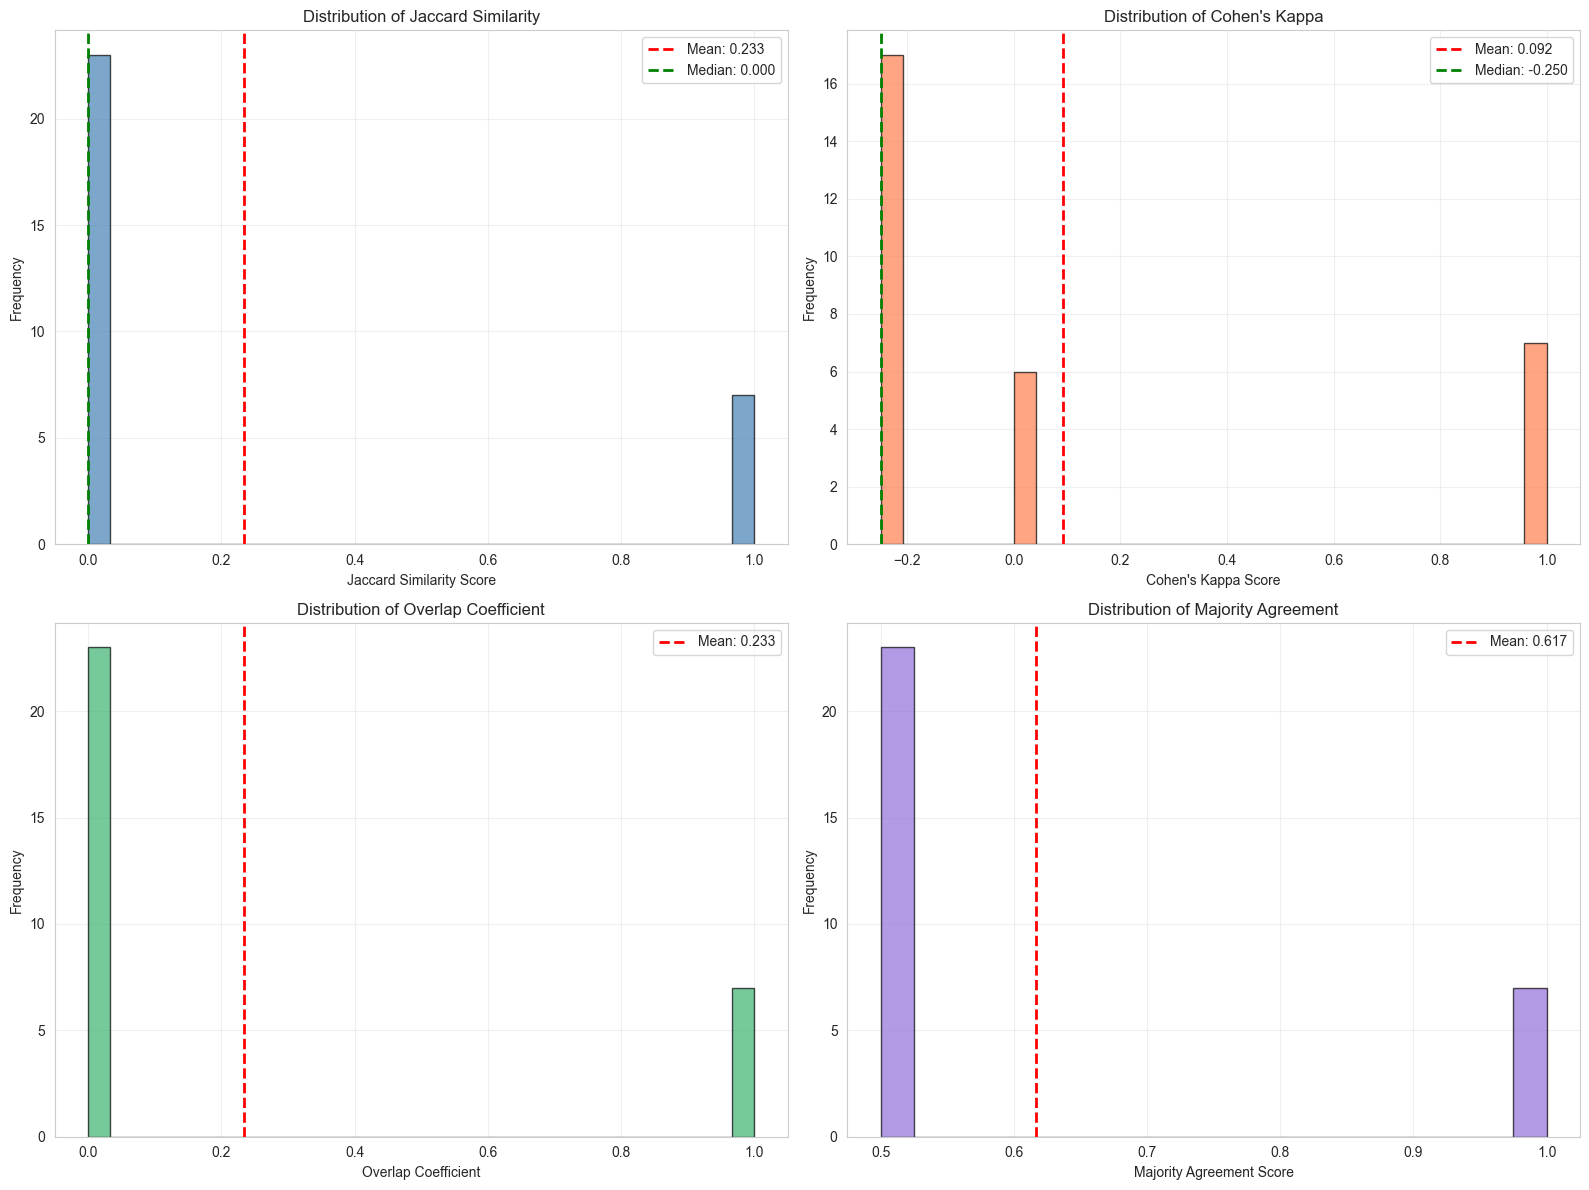

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Jaccard distribution
axes[0, 0].hist(consensus_df['jaccard_score'], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].axvline(metrics['mean_jaccard'], color='r', linestyle='--', linewidth=2, label=f'Mean: {metrics["mean_jaccard"]:.3f}')
axes[0, 0].axvline(metrics['median_jaccard'], color='g', linestyle='--', linewidth=2, label=f'Median: {metrics["median_jaccard"]:.3f}')
axes[0, 0].set_xlabel('Jaccard Similarity Score')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Jaccard Similarity')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)


# Cohen's Kappa distribution
axes[0, 1].hist(consensus_df['cohens_kappa'], bins=30, edgecolor='black', alpha=0.7, color='coral')
axes[0, 1].axvline(metrics['mean_kappa'], color='r', linestyle='--', linewidth=2, label=f'Mean: {metrics["mean_kappa"]:.3f}')
axes[0, 1].axvline(metrics['median_kappa'], color='g', linestyle='--', linewidth=2, label=f'Median: {metrics["median_kappa"]:.3f}')
axes[0, 1].set_xlabel("Cohen's Kappa Score")
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title("Distribution of Cohen's Kappa")
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Overlap Coefficient
axes[1, 0].hist(consensus_df['overlap_coefficient'], bins=30, edgecolor='black', alpha=0.7, color='mediumseagreen')
axes[1, 0].axvline(metrics['mean_overlap'], color='r', linestyle='--', linewidth=2, label=f'Mean: {metrics["mean_overlap"]:.3f}')
axes[1, 0].set_xlabel('Overlap Coefficient')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of Overlap Coefficient')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Majority Agreement
axes[1, 1].hist(consensus_df['majority_agreement'], bins=20, edgecolor='black', alpha=0.7, color='mediumpurple')
axes[1, 1].axvline(metrics['mean_majority'], color='r', linestyle='--', linewidth=2, label=f'Mean: {metrics["mean_majority"]:.3f}')
axes[1, 1].set_xlabel('Majority Agreement Score')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Distribution of Majority Agreement')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Correlation Between Metrics

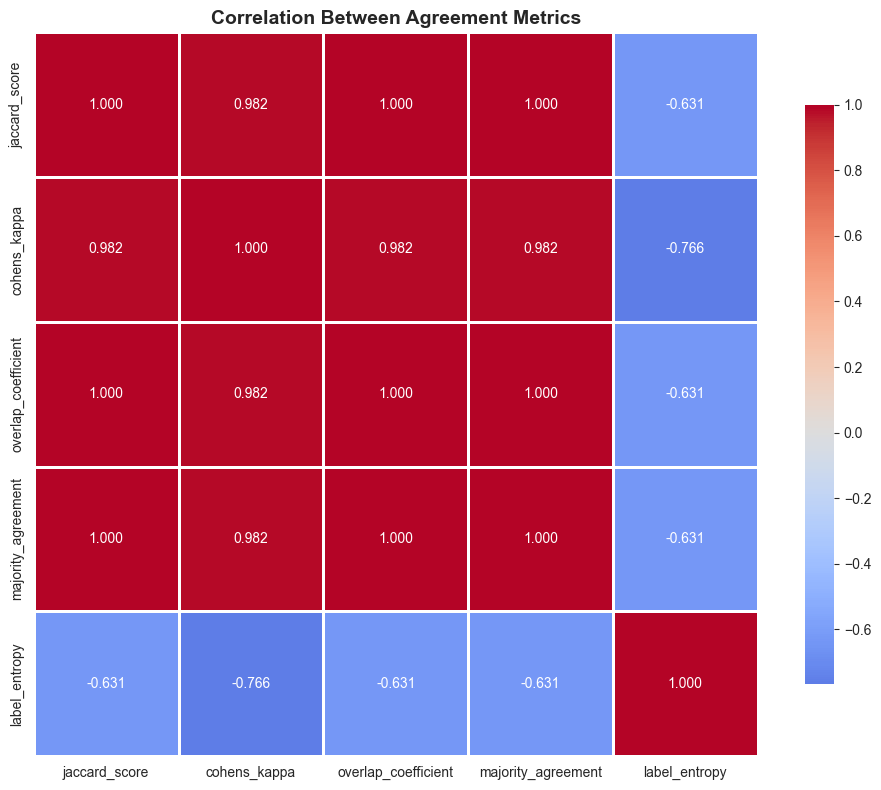


Key Correlations:
  jaccard_score             vs cohens_kappa             :  0.982
  jaccard_score             vs overlap_coefficient      :  1.000
  jaccard_score             vs majority_agreement       :  1.000
  jaccard_score             vs label_entropy            : -0.631
  cohens_kappa              vs overlap_coefficient      :  0.982
  cohens_kappa              vs majority_agreement       :  0.982
  cohens_kappa              vs label_entropy            : -0.766
  overlap_coefficient       vs majority_agreement       :  1.000
  overlap_coefficient       vs label_entropy            : -0.631
  majority_agreement        vs label_entropy            : -0.631


In [19]:
# Correlation matrix
correlation_cols = ['jaccard_score', 'cohens_kappa', 'overlap_coefficient', 'majority_agreement', 'label_entropy']
corr_matrix = consensus_df[correlation_cols].corr()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax)
ax.set_title('Correlation Between Agreement Metrics', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nKey Correlations:")
for i in range(len(correlation_cols)):
    for j in range(i+1, len(correlation_cols)):
        corr_val = corr_matrix.iloc[i, j]
        print(f"  {correlation_cols[i]:<25} vs {correlation_cols[j]:<25}: {corr_val:6.3f}")

## 6. Agreement by Number of Annotators (Multi-Metric)

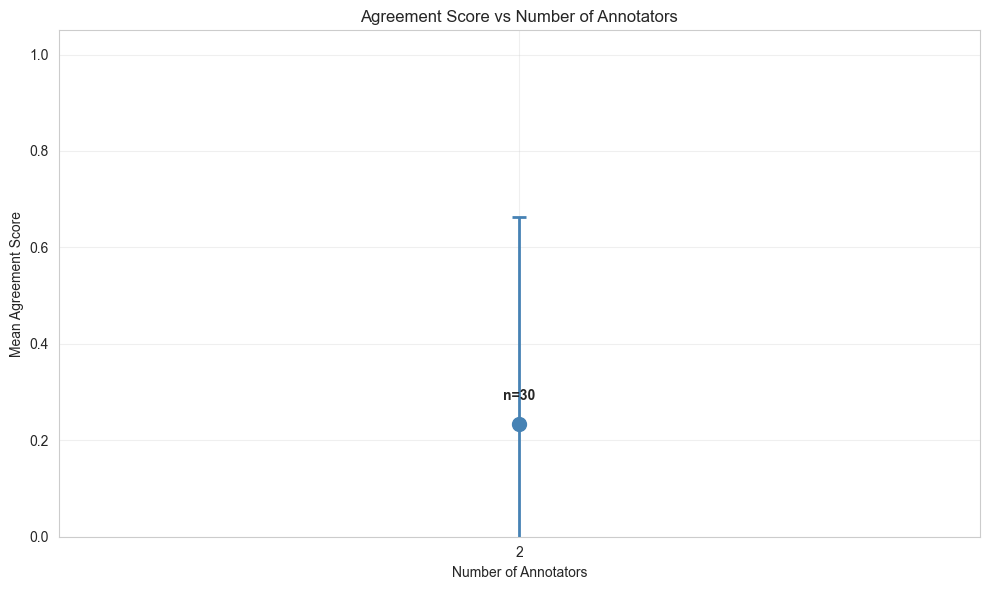

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics_to_plot = [
    ('jaccard_score', 'Jaccard Similarity', 'steelblue'),
    ('cohens_kappa', "Cohen's Kappa", 'coral'),
    ('overlap_coefficient', 'Overlap Coefficient', 'mediumseagreen'),
    ('majority_agreement', 'Majority Agreement', 'mediumpurple')
]

for idx, (metric, title, color) in enumerate(metrics_to_plot):
    ax = axes[idx // 2, idx % 2]
    
    grouped = consensus_df.groupby('num_annotators')[metric].agg(['mean', 'std', 'count'])
    
    ax.errorbar(grouped.index, grouped['mean'], yerr=grouped['std'], 
                fmt='o-', capsize=5, capthick=2, markersize=10, linewidth=2, color=color)
    ax.set_xlabel('Number of Annotators')
    ax.set_ylabel(f'Mean {title}')
    ax.set_title(f'{title} vs Number of Annotators')
    ax.set_xticks(grouped.index)
    ax.grid(True, alpha=0.3)
    ax.set_ylim([0, 1.05])
    
    # Add count labels
    for idx_val, count in grouped['count'].items():
        ax.text(idx_val, grouped.loc[idx_val, 'mean'] + 0.05, f'n={int(count)}', 
                ha='center', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

## 7. Label Distribution and Consensus Analysis

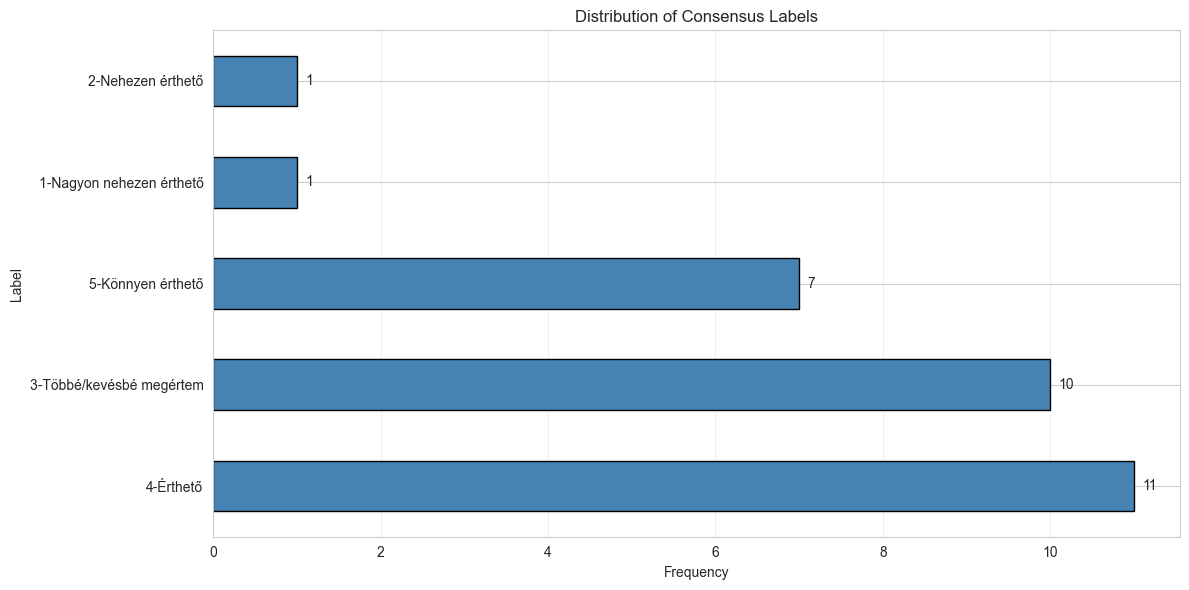


Top 10 Most Common Labels:
consensus_label
4-Érthető                   11
3-Többé/kevésbé megértem    10
5-Könnyen érthető            7
1-Nagyon nehezen érthető     1
2-Nehezen érthető            1
Name: count, dtype: int64


In [ ]:
# Label frequency analysis
label_counts = consensus_df['consensus_label'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Horizontal bar chart for top labels
top_n = min(20, len(label_counts))
label_counts.head(top_n).plot(kind='barh', ax=axes[0], color='steelblue', edgecolor='black')
axes[0].set_xlabel('Frequency')
axes[0].set_ylabel('Consensus Label')
axes[0].set_title(f'Top {top_n} Most Common Consensus Labels')
axes[0].grid(True, alpha=0.3, axis='x')

# Add value labels
for i, v in enumerate(label_counts.head(top_n)):
    axes[0].text(v + 0.5, i, str(v), va='center', fontweight='bold')

# Label entropy distribution
axes[1].hist(consensus_df['label_entropy'], bins=30, edgecolor='black', alpha=0.7, color='darkorange')
axes[1].axvline(metrics['mean_entropy'], color='r', linestyle='--', linewidth=2, 
                label=f'Mean: {metrics["mean_entropy"]:.3f}')
axes[1].set_xlabel('Label Entropy (Diversity)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Label Diversity')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nLabel Statistics:")
print(f"  Total unique consensus labels: {len(label_counts)}")
print(f"  Most common label: '{label_counts.index[0]}' ({label_counts.iloc[0]} tasks)")
print(f"  Labels appearing only once: {(label_counts == 1).sum()}")

## 8. Agreement Scatter Matrix

In [ ]:
# Create scatter matrix
metrics_for_scatter = ['jaccard_score', 'cohens_kappa', 'overlap_coefficient', 'majority_agreement']

fig, axes = plt.subplots(len(metrics_for_scatter), len(metrics_for_scatter), figsize=(16, 16))

for i, metric1 in enumerate(metrics_for_scatter):
    for j, metric2 in enumerate(metrics_for_scatter):
        ax = axes[i, j]
        
        if i == j:
            # Diagonal: histogram
            ax.hist(consensus_df[metric1], bins=20, edgecolor='black', alpha=0.7, color='steelblue')
            ax.set_ylabel('Frequency')
        else:
            # Off-diagonal: scatter plot
            scatter = ax.scatter(consensus_df[metric2], consensus_df[metric1], 
                               c=consensus_df['num_annotators'], cmap='viridis', 
                               alpha=0.6, edgecolors='black', linewidth=0.5)
            
            # Add correlation coefficient
            corr = consensus_df[[metric1, metric2]].corr().iloc[0, 1]
            ax.text(0.05, 0.95, f'r={corr:.3f}', transform=ax.transAxes, 
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                   verticalalignment='top')
        
        # Labels
        if i == len(metrics_for_scatter) - 1:
            ax.set_xlabel(metric2.replace('_', ' ').title())
        if j == 0:
            ax.set_ylabel(metric1.replace('_', ' ').title())
        
        ax.grid(True, alpha=0.3)

# Add colorbar
cbar = plt.colorbar(scatter, ax=axes, location='right', shrink=0.6)
cbar.set_label('Number of Annotators', rotation=270, labelpad=20)

plt.suptitle('Agreement Metrics Scatter Matrix', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

## 9. Low Agreement Tasks (Quality Control)

In [ ]:
# Show tasks with low agreement across multiple metrics
low_jaccard = consensus_df[consensus_df['jaccard_score'] < 0.5].sort_values('jaccard_score')
low_kappa = consensus_df[consensus_df['cohens_kappa'] < 0.2].sort_values('cohens_kappa')

print(f"\n{'='*80}")
print(f"LOW AGREEMENT TASKS - QUALITY CONTROL")
print(f"{'='*80}")

print(f"\nTasks with Low Jaccard Score (<0.5): {len(low_jaccard)} tasks")
if len(low_jaccard) > 0:
    print(low_jaccard[['task_id', 'num_annotators', 'jaccard_score', 'cohens_kappa', 'consensus_label']].head(10).to_string(index=False))

print(f"\n\nTasks with Low Cohen's Kappa (<0.2): {len(low_kappa)} tasks")
if len(low_kappa) > 0:
    print(low_kappa[['task_id', 'num_annotators', 'jaccard_score', 'cohens_kappa', 'consensus_label']].head(10).to_string(index=False))

# Tasks needing review
needs_review = consensus_df[
    (consensus_df['jaccard_score'] < 0.5) | 
    (consensus_df['cohens_kappa'] < 0.2)
].sort_values('jaccard_score')

print(f"\n\nTotal tasks needing review: {len(needs_review)}")

# Visualization of problematic tasks
if len(needs_review) > 0:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    scatter = ax.scatter(needs_review['jaccard_score'], needs_review['cohens_kappa'],
                        c=needs_review['num_annotators'], s=100, cmap='Reds',
                        alpha=0.6, edgecolors='black', linewidth=1)
    
    ax.axvline(0.5, color='red', linestyle='--', alpha=0.5, label='Jaccard threshold')
    ax.axhline(0.2, color='blue', linestyle='--', alpha=0.5, label='Kappa threshold')
    
    ax.set_xlabel('Jaccard Score')
    ax.set_ylabel("Cohen's Kappa")
    ax.set_title('Tasks Needing Review (Low Agreement)', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Number of Annotators')
    
    plt.tight_layout()
    plt.show()


Tasks with Low Agreement (<0.5):
Total: 23

    task_id  num_annotators  agreement_score           consensus_label
0       232               2              0.0         5-Könnyen érthető
27      212               2              0.0                 4-Érthető
26      211               2              0.0  3-Többé/kevésbé megértem
24      209               2              0.0  3-Többé/kevésbé megértem
23      208               2              0.0  3-Többé/kevésbé megértem
22      207               2              0.0         5-Könnyen érthető
20      205               2              0.0  3-Többé/kevésbé megértem
19      204               2              0.0                 4-Érthető
18      203               2              0.0         5-Könnyen érthető
16      201               2              0.0         5-Könnyen érthető


## 10. Export Comprehensive Results

In [ ]:
# Create output directory
output_dir = Path(json_directory).parent / "analysis_results"
output_dir.mkdir(exist_ok=True, parents=True)

# Save comprehensive consensus results
consensus_df_export = consensus_df.drop(columns=['all_labels'])  # Remove list column for CSV
consensus_df_export.to_csv(output_dir / "comprehensive_consensus_results.csv", index=False)

# Save metrics summary
metrics_df = pd.DataFrame([metrics])
metrics_df.to_csv(output_dir / "comprehensive_metrics_summary.csv", index=False)

# Save low agreement tasks for review
needs_review.to_csv(output_dir / "tasks_needing_review.csv", index=False)

# Save label statistics
label_stats = pd.DataFrame({
    'label': label_counts.index,
    'frequency': label_counts.values
})
label_stats.to_csv(output_dir / "label_frequency_distribution.csv", index=False)

# Save correlation matrix
corr_matrix.to_csv(output_dir / "metrics_correlation_matrix.csv")

print(f"✓ Results saved to: {output_dir}")
print(f"  - comprehensive_consensus_results.csv")
print(f"  - comprehensive_metrics_summary.csv")
print(f"  - tasks_needing_review.csv")
print(f"  - label_frequency_distribution.csv")
print(f"  - metrics_correlation_matrix.csv")

## 11. Summary Dashboard

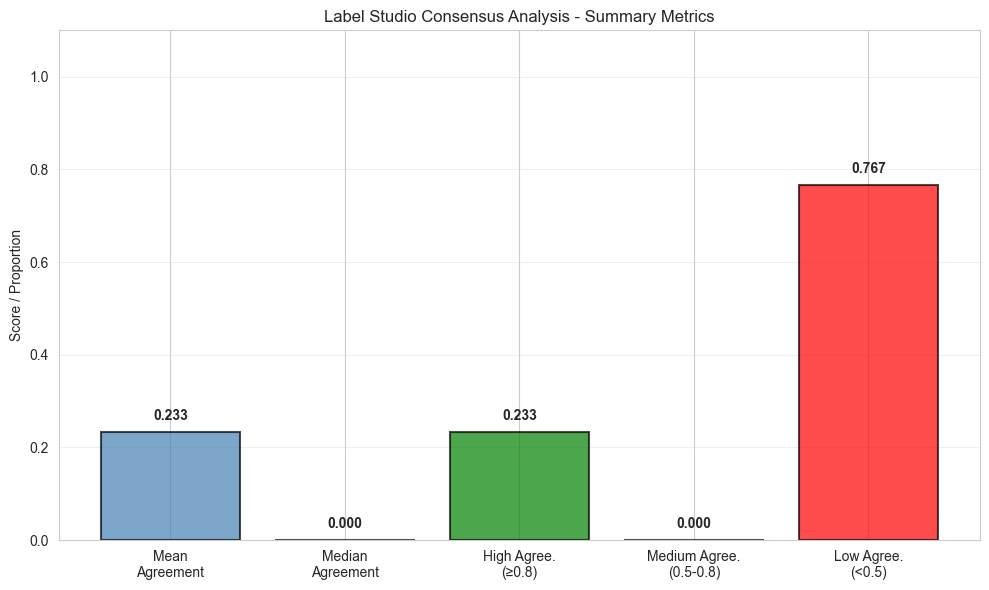

In [ ]:
fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Overall metrics comparison
ax1 = fig.add_subplot(gs[0, :])
metric_names = ['Jaccard', 'Cohen\'s\nKappa', 'Overlap\nCoeff.', 'Majority\nAgree.']
metric_values = [metrics['mean_jaccard'], metrics['mean_kappa'], 
                 metrics['mean_overlap'], metrics['mean_majority']]
colors_bar = ['steelblue', 'coral', 'mediumseagreen', 'mediumpurple']

bars = ax1.bar(metric_names, metric_values, color=colors_bar, alpha=0.7, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Score')
ax1.set_title('Mean Agreement Scores Across All Metrics', fontsize=14, fontweight='bold')
ax1.set_ylim([0, 1.1])
ax1.grid(True, alpha=0.3, axis='y')
ax1.axhline(0.8, color='green', linestyle='--', alpha=0.5, label='High threshold')
ax1.axhline(0.5, color='orange', linestyle='--', alpha=0.5, label='Medium threshold')
ax1.legend(loc='upper right')

for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{height:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

# 2. Task distribution pie chart
ax2 = fig.add_subplot(gs[1, 0])
sizes = [metrics['high_agreement_tasks'], metrics['medium_agreement_tasks'], metrics['low_agreement_tasks']]
labels_pie = [f'High\n({sizes[0]})', f'Medium\n({sizes[1]})', f'Low\n({sizes[2]})']
colors_pie = ['green', 'orange', 'red']
ax2.pie(sizes, labels=labels_pie, colors=colors_pie, autopct='%1.1f%%', startangle=90, 
        explode=(0.05, 0, 0), shadow=True)
ax2.set_title('Task Distribution by\nAgreement Level', fontweight='bold')

# 3. Annotator distribution
ax3 = fig.add_subplot(gs[1, 1])
annotator_counts = consensus_df['num_annotators'].value_counts().sort_index()
ax3.bar(annotator_counts.index, annotator_counts.values, color='steelblue', alpha=0.7, edgecolor='black')
ax3.set_xlabel('Number of Annotators')
ax3.set_ylabel('Number of Tasks')
ax3.set_title('Tasks by Number of Annotators', fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')

# 4. Label diversity
ax4 = fig.add_subplot(gs[1, 2])
ax4.hist(consensus_df['num_unique_labels'], bins=range(1, int(consensus_df['num_unique_labels'].max()) + 2), 
         color='darkorange', alpha=0.7, edgecolor='black')
ax4.set_xlabel('Number of Unique Labels per Task')
ax4.set_ylabel('Frequency')
ax4.set_title('Label Diversity Distribution', fontweight='bold')
ax4.grid(True, alpha=0.3)

# 5. Kappa interpretation gauge
ax5 = fig.add_subplot(gs[2, :])
kappa_val = metrics['mean_kappa']
kappa_categories = ['Poor\n(<0)', 'Slight\n(0-0.2)', 'Fair\n(0.2-0.4)', 
                   'Moderate\n(0.4-0.6)', 'Substantial\n(0.6-0.8)', 'Almost Perfect\n(0.8-1.0)']
kappa_ranges = [-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1.0]
kappa_colors = ['darkred', 'red', 'orange', 'yellow', 'lightgreen', 'green']

for i in range(len(kappa_ranges)-1):
    ax5.barh(0, kappa_ranges[i+1] - kappa_ranges[i], left=kappa_ranges[i], 
            color=kappa_colors[i], alpha=0.7, edgecolor='black', height=0.5)
    mid_point = (kappa_ranges[i] + kappa_ranges[i+1]) / 2
    ax5.text(mid_point, 0, kappa_categories[i], ha='center', va='center', 
            fontweight='bold', fontsize=9)

ax5.axvline(kappa_val, color='blue', linewidth=3, label=f'Mean Kappa: {kappa_val:.3f}')
ax5.scatter([kappa_val], [0], s=200, color='blue', zorder=5, marker='v')
ax5.set_xlim([-0.2, 1.0])
ax5.set_ylim([-1, 1])
ax5.set_xlabel("Cohen's Kappa Value", fontsize=12)
ax5.set_title(f"Cohen's Kappa Interpretation: {interpret_kappa(kappa_val)}", 
             fontsize=14, fontweight='bold')
ax5.set_yticks([])
ax5.legend(loc='upper left')
ax5.grid(True, alpha=0.3, axis='x')

plt.suptitle('Label Studio Consensus Analysis - Summary Dashboard', 
            fontsize=16, fontweight='bold', y=0.995)
plt.show()

## 12. Final Summary Report

In [ ]:
print("\n" + "="*80)
print("FINAL CONSENSUS ANALYSIS REPORT")
print("="*80)
print(f"\n📊 Dataset Overview:")
print(f"   • Total annotations analyzed: {len(analyzer.annotations)}")
print(f"   • Tasks with multiple annotations: {len(consensus_df)}")
print(f"   • Unique labels found: {len(all_labels_set)}")
print(f"   • Average annotators per task: {consensus_df['num_annotators'].mean():.2f}")

print(f"\n📈 Agreement Metrics (Mean ± Std):")
print(f"   • Jaccard Similarity:    {metrics['mean_jaccard']:.3f} ± {metrics['std_jaccard']:.3f}")
print(f"   • Cohen's Kappa:         {metrics['mean_kappa']:.3f} ± {metrics['std_kappa']:.3f}")
print(f"   • Overlap Coefficient:   {metrics['mean_overlap']:.3f}")
print(f"   • Majority Agreement:    {metrics['mean_majority']:.3f}")

print(f"\n🎯 Agreement Quality:")
print(f"   • Kappa interpretation: {interpret_kappa(metrics['mean_kappa'])}")
print(f"   • High agreement tasks (≥0.8): {metrics['high_agreement_tasks']} ({metrics['high_agreement_tasks']/metrics['total_tasks']*100:.1f}%)")
print(f"   • Tasks needing review: {len(needs_review)} ({len(needs_review)/metrics['total_tasks']*100:.1f}%)")

print(f"\n⚠️  Quality Control:")
print(f"   • Low Jaccard tasks (<0.5): {metrics['low_agreement_tasks']}")
print(f"   • Low Kappa tasks (<0.2): {len(low_kappa)}")
print(f"   • Mean label entropy: {metrics['mean_entropy']:.3f}")

print(f"\n💡 Recommendations:")
if metrics['mean_kappa'] < 0.4:
    print(f"   ⚠️  Agreement is Fair or below - consider:")
    print(f"      - Reviewing annotation guidelines")
    print(f"      - Providing more training to annotators")
    print(f"      - Clarifying ambiguous label definitions")
elif metrics['mean_kappa'] < 0.6:
    print(f"   ⚡ Agreement is Moderate - consider:")
    print(f"      - Reviewing low-agreement tasks")
    print(f"      - Adding more examples to guidelines")
else:
    print(f"   ✅ Agreement is Substantial or better - quality looks good!")
    print(f"      - Review {len(needs_review)} tasks flagged for quality control")

print(f"\n📁 Output files saved to: {output_dir}")
print("="*80 + "\n")